In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [4]:
# Reading train CSV file directly from Web, and store it in a pandas DataFrame:
train = pd.read_csv('D:/Fauzan/Study PhD/Semester 1/Machine Learning/Homework/HW4/spooky-author-identification/spooky-author-identification/train/train.csv')

# Print first 5 rows
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [5]:
# Reading test CSV file directly from Web, and store it in a pandas DataFrame:
test = pd.read_csv("D:/Fauzan/Study PhD/Semester 1/Machine Learning/Homework/HW4/spooky-author-identification/spooky-author-identification/test/test.csv")

# Print first 5 rows
test.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [6]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [7]:
lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train.author.values)

In [8]:
xtrain, xvalid, ytrain, yvalid = train_test_split(train.text.values, y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.1, shuffle=True)

In [9]:
# Always start with these features. They work (almost) everytime!
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

In [10]:
ctv = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), stop_words = 'english')

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain) + list(xvalid))
xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

In [11]:
# Apply SVD, I chose 120 components. 120-200 components are good enough for SVM model.
svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xvalid_svd = svd.transform(xvalid_tfv)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xvalid_svd_scl = scl.transform(xvalid_svd)

### Linear SVM

In [12]:
# Fitting a simple SVM
clf = SVC(C=1.0, probability=True) # since we need probabilities
clf.fit(xtrain_svd_scl, ytrain)
predictions = clf.predict_proba(xvalid_svd_scl)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.734 


C:\Users\VIPLab\anaconda3\envs\pytorch_gpu\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\VIPLab\anaconda3\envs\pytorch_gpu\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


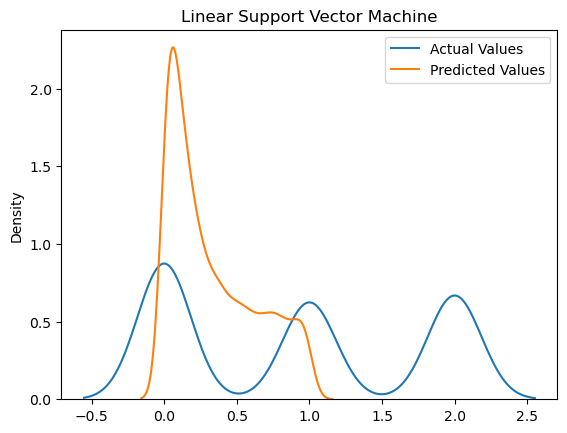

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.distplot(yvalid,hist=False,label='Actual Values')
ax = sns.distplot(predictions,hist=False,label='Predicted Values')
ax.set_title('Linear Support Vector Machine')
plt.legend()

In [19]:
clf.score(xvalid_svd_scl, yvalid)

0.6818181818181818

In [20]:
y_pred = clf.predict(xvalid_svd_scl)

In [23]:
from sklearn.metrics import accuracy_score,confusion_matrix

accuracy_score(yvalid,y_pred)

0.6818181818181818

In [24]:
confusion_matrix(yvalid,y_pred)

array([[584, 113,  93],
       [144, 369,  51],
       [165,  57, 382]], dtype=int64)

<AxesSubplot:>

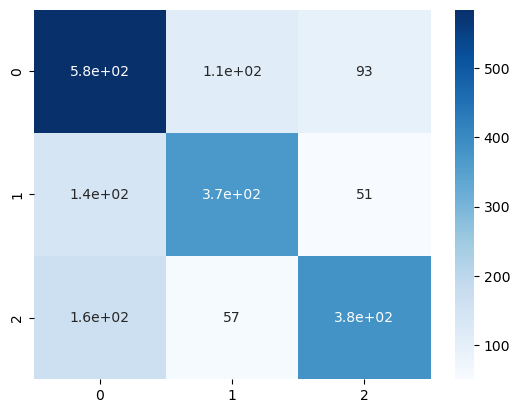

In [25]:
sns.heatmap(confusion_matrix(yvalid,y_pred),annot=True,cmap='Blues')

In [26]:
from sklearn.metrics import classification_report

print(classification_report(yvalid, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.74      0.69       790
           1       0.68      0.65      0.67       564
           2       0.73      0.63      0.68       604

    accuracy                           0.68      1958
   macro avg       0.69      0.68      0.68      1958
weighted avg       0.69      0.68      0.68      1958



### Radical SVM

In [27]:
# Fitting a radical SVM
clf = SVC(kernel='rbf',C=1, gamma=0.22, probability=True) # since we need probabilities
clf.fit(xtrain_svd_scl, ytrain)
predictions = clf.predict_proba(xvalid_svd_scl)

print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 1.044 


C:\Users\VIPLab\anaconda3\envs\pytorch_gpu\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\VIPLab\anaconda3\envs\pytorch_gpu\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


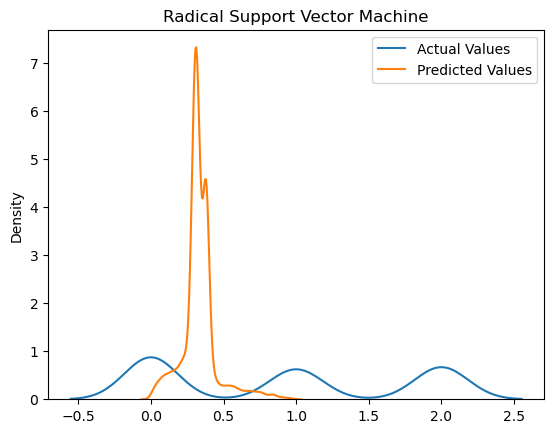

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.distplot(yvalid,hist=False,label='Actual Values')
ax = sns.distplot(predictions,hist=False,label='Predicted Values')
ax.set_title('Radical Support Vector Machine')
plt.legend()

In [29]:
clf.score(xvalid_svd_scl, yvalid)

0.43156281920326867

In [30]:
y_pred = clf.predict(xvalid_svd_scl)

In [31]:
from sklearn.metrics import accuracy_score,confusion_matrix

accuracy_score(yvalid,y_pred)

0.43156281920326867

In [32]:
confusion_matrix(yvalid,y_pred)

array([[721,  40,  29],
       [486,  57,  21],
       [522,  15,  67]], dtype=int64)

<AxesSubplot:>

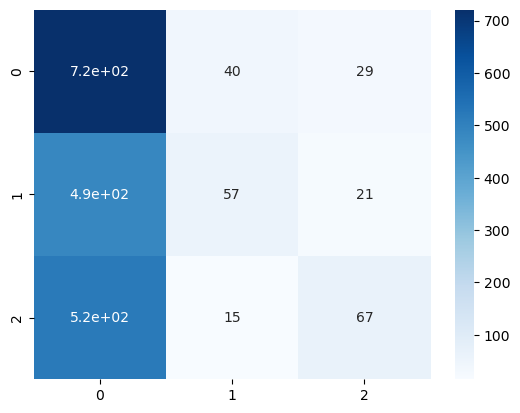

In [33]:
sns.heatmap(confusion_matrix(yvalid,y_pred),annot=True,cmap='Blues')

In [34]:
from sklearn.metrics import classification_report

print(classification_report(yvalid, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.91      0.57       790
           1       0.51      0.10      0.17       564
           2       0.57      0.11      0.19       604

    accuracy                           0.43      1958
   macro avg       0.50      0.37      0.31      1958
weighted avg       0.49      0.43      0.34      1958

